# Closure test of Bayesian analysis

In [1]:
# prepare
import subprocess
from multiprocessing import Pool, cpu_count
import os, pickle, math, time

import numpy as np
from numpy.linalg import inv

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
# sns.set("notebook")
sns.color_palette('Set2')
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl

import scipy.stats as st
from scipy import optimize
from scipy.linalg import lapack

from pyDOE import lhs
import emcee
import h5py

FW = 600

path = '/mnt/d/research/Bayesian/BayesianAnalysis-Tequila'

def save_fig(fig_id):
    plt.savefig(path+fig_id, format='png', dpi=300)
    
def hist_1d_2d(X, Y, nameX, nameY):
    left, width = 0.1, 0.75
    bottom, height = 0.1, 0.75
    spacing = 0.005
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.15]
    rect_histy = [left + width + spacing, bottom, 0.15, height]

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes(rect_scatter)
    ax1 = fig.add_axes(rect_histx, sharex=ax)
    ax2 = fig.add_axes(rect_histy, sharey=ax)
    ax1.tick_params(axis="x", labelbottom=False)
    ax2.tick_params(axis="y", labelleft=False)

    ax.scatter(X, Y)
    ax1.hist(X, density=True)
    ax2.hist(Y, orientation='horizontal', density=True)
    ax.set_xlabel(nameX)
    ax.set_ylabel(nameY)


## Gaussian emulator

In [2]:
# Gaussian emulator

simulation = np.loadtxt(os.path.join(path, 'data', 'running_coupling', 'output_4obs'))
simulation_err = np.loadtxt(os.path.join(path, 'data', 'running_coupling', 'output_err_4obs'))

use_NL = True
Y_model = np.sqrt(simulation) if use_NL else simulation

SS  =  StandardScaler(copy=True)
Npc = 4
pca = PCA(copy=True, whiten=True, svd_solver='full')
# Keep only the first `npc` principal components
pc_tf_data = pca.fit_transform(SS.fit_transform(Y_model)) [:,:Npc]

# The transformation matrix from PC to Physical space
inverse_tf_matrix = pca.components_ * np.sqrt(pca.explained_variance_[:, np.newaxis]) * SS.scale_ 
inverse_tf_matrix = inverse_tf_matrix[:Npc,:]


np.savetxt(path+'/data/inverse_tf_matrix', inverse_tf_matrix)
np.savetxt(path+'/data/PCA_transformed_data', pc_tf_data)

design = np.loadtxt(path+'/data/running_coupling/new_param/lhd_sampling_5d.txt')
# design = design[:32]
design_max = np.array([2., 2., 0.6, 3.5, 0.4])
design_min = np.array([-0.8, -0.8, 0.16, 1.15, 0.1])
design_ptp = design_max - design_min
# design_ptp = np.array([1.9, 1.9, 1.9, 0.34, 2., 0.3])

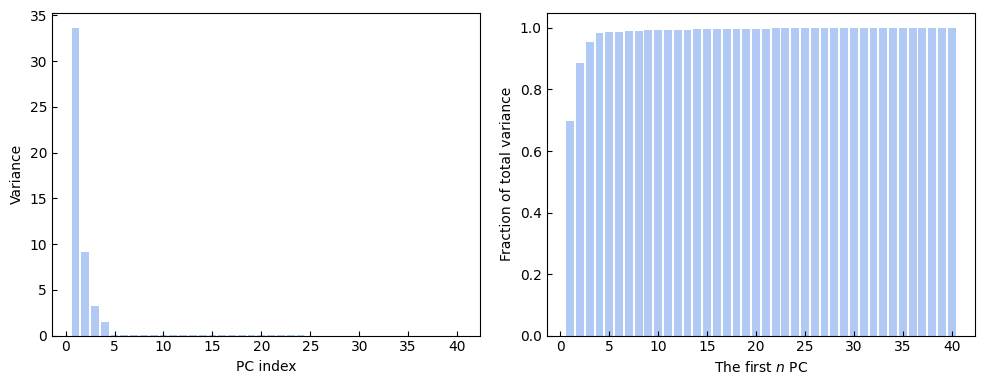

In [3]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
importance = pca.explained_variance_
cumulateive_importance = np.cumsum(importance)/np.sum(importance)
idx = np.arange(1,1+len(importance))
ax1.bar(idx,importance, alpha=0.5, color='cornflowerblue')
ax1.set_xlabel("PC index")
ax1.set_ylabel("Variance")
# ax1.set_yscale("log")
ax2.bar(idx,cumulateive_importance, alpha=0.5, color='cornflowerblue')
ax2.set_xlabel(r"The first $n$ PC")
ax2.set_ylabel("Fraction of total variance")
plt.tight_layout()
ax1.tick_params(direction="in", which='both')
ax2.tick_params(direction="in", which='both')
plt.savefig(path+"/plots/running_coupling/PC_importance_2obs")

In [4]:
print(cumulateive_importance)

[0.69779203 0.88645334 0.95355582 0.98403559 0.98619477 0.98821056
 0.98959443 0.99081906 0.99175254 0.99262712 0.9934485  0.99420272
 0.99482612 0.99539828 0.99594155 0.99644937 0.99691673 0.99729396
 0.99764002 0.99795654 0.99822802 0.99849129 0.99871699 0.99891559
 0.9990875  0.99924762 0.99938118 0.9994944  0.99959241 0.9996801
 0.99975669 0.99981092 0.99985968 0.99989774 0.99993493 0.99996351
 0.99998656 0.99999482 1.         1.        ]


In [5]:
transformed = SS.fit_transform(Y_model)

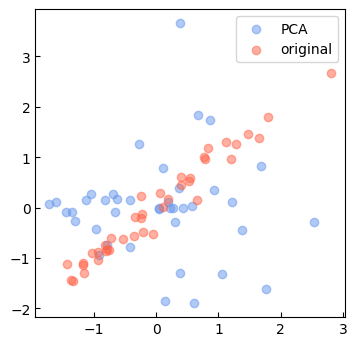

In [6]:
plt.figure(figsize=(4, 4))
plt.scatter(pc_tf_data.T[0], pc_tf_data.T[1], label='PCA', color='cornflowerblue', alpha=0.5)
plt.scatter(transformed.T[0], transformed.T[1], label='original', color='tomato', alpha=0.5)
plt.legend()
plt.tick_params(direction="in", which='both')
plt.savefig('PCA_orthogonal')

In [7]:
EMU = path+'/data/running_coupling/emulators.dat'
Emulators=[]
for i in range(0,Npc):
    start_time = time.time()
    kernel=1*krnl.RBF(length_scale=design_ptp,
                          length_scale_bounds=np.outer(design_ptp, (1./5, 1e2))) + krnl.WhiteKernel(noise_level=.01, 
                                  noise_level_bounds=(1e-4, 1e4))
    print("-----------------")
    print("Training PC #",i+1)
    GPR=gpr(kernel=kernel,n_restarts_optimizer=0)
    GPR.fit(design, pc_tf_data[:,i].reshape(-1,1))
    print('GPR score: {:1.3f}'.format(GPR.score(design,pc_tf_data[:,i])) )
    print("time: {:1.3f} seconds".format(time.time() - start_time))
    Emulators.append(GPR)
    
with open(EMU, "wb") as f:
    pickle.dump(Emulators,f)

-----------------
Training PC # 1
GPR score: 0.816
time: 0.085 seconds
-----------------
Training PC # 2
GPR score: 0.353
time: 0.060 seconds
-----------------
Training PC # 3
GPR score: 0.652
time: 0.049 seconds
-----------------
Training PC # 4
GPR score: 0.515
time: 0.063 seconds


/home/tianyu/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 280.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/tianyu/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 235.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/tianyu/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 280.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/tianyu/.local/lib/python3.8/site-packages/sklearn/gauss

In [ ]:
Xdim = 5
use_NL = True
def predict_observables(model_parameters, diag_std=False):
    """Predicts the observables for any model parameter value using the trained emulators.
    
    Parameters
    ----------
    Theta_input : Model parameter values.
    Return
    ------
    Mean value and full error covaraiance matrix of the prediction is returened. """

    mean=[]
    variance=[]
    theta=np.array(model_parameters).flatten()
    if len(theta)!=Xdim:
        raise TypeError('The input model_parameters array does not have the right dimensions')
    else: 
        theta=np.array(theta).reshape(1,Xdim)
        for i in range(Npc):
            mn,std=Emulators[i].predict(theta, return_std=True)
            mean.append(mn)
            variance.append(std**2)
    mean=np.array(mean).reshape(1,-1)
    inverse_transformed_mean = mean@inverse_tf_matrix + np.array(SS.mean_).reshape(1,-1)    
    variance_matrix = np.diag(np.array(variance).flatten())
    inverse_transformed_variance = np.einsum('ik,kl,lj-> ij', inverse_tf_matrix.T, variance_matrix, inverse_tf_matrix, 
                                             optimize=False)
    if use_NL:
        inverse_transformed_mean = inverse_transformed_mean**2
        inverse_transformed_variance *= np.outer(2.*inverse_transformed_mean[0]**.5, 
                                                 2.*inverse_transformed_mean[0]**.5)
    if diag_std:
        return inverse_transformed_mean[0], np.sqrt(np.diag(inverse_transformed_variance))
    else:
        return inverse_transformed_mean[0], inverse_transformed_variance



In [ ]:
X_validation = np.array([[0, 0, 0.3, 1.6, 0.25]])

# Next, get the emulator prediction and uncertainty
A = np.array([predict_observables(it, diag_std=True) for it in X_validation])
Y_predicted = A[:,0,:]
Y_std = A[:,1,:]
np.savetxt(path+'/data/running_coupling/data_predicted', Y_predicted)
np.savetxt(path+'/data/running_coupling/data_predicted_err', Y_std)

In [ ]:
pT1 = np.array([8.25, 8.75, 9.25, 9.75, 11, 13, 15, 17, 19])
Nc1 = 9
pT3 = np.array([10.75, 12.35, 14.15, 16.2, 18.6, 21.35, 24.45, 28.05, 33.85, 42.6, 53.65, 67.55, 85.05, 106.9, 134.5])
Nc2 = 9 + Nc1
pT2 = np.array([8.25, 8.75, 9.25, 9.75, 11, 13, 15, 17, 19])
Nc3 = 15 + Nc2
pT4 = np.array([10.75, 12.35, 14.15, 16.2, 18.6, 21.35, 24.45, 28.05, 33.85, 42.6, 53.65, 67.55, 85.05, 106.9])
Nc4 = 14 + Nc3

In [ ]:
Y_validation = np.array([np.loadtxt(path+'/data/running_coupling/data_val_4obs')])
Y_validation_err = np.array([np.loadtxt(path+'/data/running_coupling/data_val_err_4obs')])
print(Y_validation.shape)

In [ ]:
param_samp = np.array([[-0.8, 0., 2.], [-0.8, 0., 2.], [0.16, 0.3, 0.6], [1.15, 1.6, 3.5], [0.1, 0.25, 0.4]])
ParameterLabels = ['$\\beta_1$', '$\\beta_2$', '$T^*$', '$Q_0$', '$\\alpha^{inel}_{s, hard}$']
colors = ['r', 'b', 'g']

fig, axes = plt.subplots(5,4, figsize=(16,16))
fig.subplots_adjust(hspace=0, wspace=0)
labels = r"$R_{AA}$"

for i, color in enumerate(colors): 
    X_validation = np.array([param_samp.T[1]])

    
    for j, param_label in enumerate(ParameterLabels): 
        X_validation[0, j] = param_samp[j, i]
        A = np.array([predict_observables(it, diag_std=True) for it in X_validation])
        Y_predicted = A[:,0,:]
        Y_std = A[:,1,:]
        for k, (mean, std) in enumerate(zip(Y_predicted, Y_std)):
            label = param_label+'=%.2f' %param_samp[j, i]
            axes[j, 0].fill_between(pT1,mean[:Nc1]-std[:Nc1],mean[:Nc1]+std[:Nc1],color=color,alpha=.2, label=label)
        for k, (mean, std) in enumerate(zip(Y_predicted, Y_std)):
            label = param_label+'=%.2f' %param_samp[j, i]
            axes[j, 1].fill_between(pT2,mean[Nc1:Nc2]-std[Nc1:Nc2],mean[Nc1:Nc2]+std[Nc1:Nc2],color=color,alpha=.2, label=label)
        for k, (mean, std) in enumerate(zip(Y_predicted, Y_std)):
            label = param_label+'=%.2f' %param_samp[j, i]
            axes[j, 2].fill_between(pT3,mean[Nc2:Nc3]-std[Nc2:Nc3],mean[Nc2:Nc3]+std[Nc2:Nc3],color=color,alpha=.2, label=label)
        for k, (mean, std) in enumerate(zip(Y_predicted, Y_std)):
            label = param_label+'=%.2f' %param_samp[j, i]
            axes[j, 3].fill_between(pT4,mean[Nc3:Nc4]-std[Nc3:Nc4],mean[Nc3:Nc4]+std[Nc3:Nc4],color=color,alpha=.2, label=label)
            
        # label = 'Model calc.' if i == 0 else ''
        axes[j, 0].errorbar(pT1, Y_validation[0][:Nc1], Y_validation_err[0][:Nc1], color='black')
        axes[j, 1].errorbar(pT2, Y_validation[0][Nc1:Nc2], Y_validation_err[0][Nc1:Nc2], color='black')
        axes[j, 2].errorbar(pT3, Y_validation[0][Nc2:Nc3], Y_validation_err[0][Nc2:Nc3], color='black')
        axes[j, 3].errorbar(pT4, Y_validation[0][Nc3:Nc4], Y_validation_err[0][Nc3:Nc4], color='black')
        # axes[j, 0].set_xlabel("$p_T$ (GeV)")
        axes[j, 0].set_ylabel(labels)
        axes[j, 0].legend()
        axes[j, 0].set_ylim(0, 1.5)
        axes[j, 0].set_xlim(8.25, 19)
        # axes[j, 1].set_xlabel("$p_T$ (GeV)")
        # axes[j, 1].set_ylabel(labels)
        axes[j, 1].legend()
        axes[j, 1].set_ylim(0, 1.5)
        axes[j, 1].set_xlim(8.25, 19)
        # axes[j, 2].set_xlabel("$p_T$ (GeV)")
        # axes[j, 2].set_ylabel(labels)
        axes[j, 2].legend()
        axes[j, 2].set_ylim(0, 1.5)
        axes[j, 2].set_xlim(10.75, 106.9)
        # axes[j, 3].set_xlabel("$p_T$ (GeV)")
        # axes[j, 3].set_ylabel(labels)
        axes[j, 3].legend()
        axes[j, 3].set_ylim(0, 1.5)
        axes[j, 3].set_xlim(10.75, 106.9)
        # axes[j, 0].tick_params(axis='y', which='both', labelleft=False)
        axes[j, 1].tick_params(axis='y', which='both', labelleft=False)
        axes[j, 2].tick_params(axis='y', which='both', labelleft=False)
        axes[j, 3].tick_params(axis='y', which='both', labelleft=False)
        axes[j, 0].tick_params(direction="in", which='both')
        axes[j, 1].tick_params(direction="in", which='both')
        axes[j, 2].tick_params(direction="in", which='both')
        axes[j, 3].tick_params(direction="in", which='both')
axes[4, 0].set_xlabel("$p_T$ (GeV)")
axes[4, 1].set_xlabel("$p_T$ (GeV)")
axes[4, 2].set_xlabel("$p_T$ (GeV)")
axes[4, 3].set_xlabel("$p_T$ (GeV)")


# titles = r"centrality 40-50%", r"centrality 40-50%"
# titles = r"Au+Au 200GeV, centrality 0-10%"
# for ax, label, title in zip(axes, labels, titles):
# axes.set_xlabel("$p_T$ (GeV)")
# axes.set_ylabel(labels)
# axes.legend()
# axes.set_ylim(0, 0.5)
axes[0, 0].set_title(r"Au+Au 200GeV, centrality 0-10%")
axes[0, 1].set_title(r"Pb+Pb 2760GeV, centrality 0-5%")
axes[0, 2].set_title(r"Au+Au 200GeV, centrality 20-30%")
axes[0, 3].set_title(r"Pb+Pb 2760GeV, centrality 30-40%")

# plt.tight_layout(True)
plt.savefig(path+"/plots/running_coupling/Emulator_validation_2pca")

In [ ]:
# Emulator validation
np.random.seed(9)
# X_validation = design_min + np.random.rand(2, Xdim)*design_ptp
# X_validation = np.array([design[0]])
# X_validation = np.array([design[0]])

# Next, get the emulator prediction and uncertainty
X_validation = np.array([[0, 0, 0.3, 1.6, 0.25]])
A = np.array([predict_observables(it, diag_std=True) for it in X_validation])
Y_predicted = A[:,0,:]
Y_std = A[:,1,:]
# print(Y_predicted.shape)


# Model calculation at these two points
# Y_validation = np.array([np.concatenate(ToyModel(param)) for param in X_validation])
# print(Y_validation.shape)
# Y_validation = np.array([simulation[0]])
Y_validation = np.array([np.loadtxt(path+'/data/running_coupling/data_val_4obs')])
Y_validation_err = np.array([np.loadtxt(path+'/data/running_coupling/data_val_err_4obs')])
# Y_validation_err = np.array([simulation_err[0]])

labels = r"$R_{AA}^{h^\pm}$"

# plot the prediction + uncertainty band with the true model caluclation
fig, axes = plt.subplots(2,2, figsize=(8,5))
fig.subplots_adjust(hspace=0, wspace=0)
for i, (mean, std) in enumerate(zip(Y_predicted, Y_std)):
    label = 'GP emulated' if i==0 else''
    axes[0, 0].fill_between(pT1,mean[:Nc1]-std[:Nc1],mean[:Nc1]+std[:Nc1],color='tomato',alpha=.5, label=label)
    axes[1, 0].fill_between(pT2,mean[Nc1:Nc2]-std[Nc1:Nc2],mean[Nc1:Nc2]+std[Nc1:Nc2],color='tomato',alpha=.5, label=label)
    axes[0, 1].fill_between(pT3,mean[Nc2:Nc3]-std[Nc2:Nc3],mean[Nc2:Nc3]+std[Nc2:Nc3],color='tomato',alpha=.5, label=label)
    axes[1, 1].fill_between(pT4,mean[Nc3:Nc4]-std[Nc3:Nc4],mean[Nc3:Nc4]+std[Nc3:Nc4],color='tomato',alpha=.5, label=label)
    # axes[1].fill_between(pT,mean[Nc:]-std[Nc:],mean[Nc:]+std[Nc:],color='r',alpha=.5, label=label)
for i, ym, ym_err in zip(range(len(Y_validation)), Y_validation, Y_validation_err):
    label = 'Model calc.' if i==0 else''
    axes[0, 0].errorbar(pT1, ym[:Nc1], yerr=ym_err[:Nc1], label=label)
    axes[1, 0].errorbar(pT2, ym[Nc1:Nc2], yerr=ym_err[Nc1:Nc2], label=label)
    axes[0, 1].errorbar(pT3, ym[Nc2:Nc3], yerr=ym_err[Nc2:Nc3], label=label)
    axes[1, 1].errorbar(pT4, ym[Nc3:Nc4], yerr=ym_err[Nc3:Nc4], label=label)
    
    # axes[1].errorbar(pT, ym[Nc:], yerr=ym_err[Nc:], label=label)
    # axes[0, 0].set_xlabel("$p_T$ (GeV)")
    axes[0, 0].set_ylabel(labels)
    # axes[0, 0].legend()
    axes[0, 0].set_ylim(0, 1.1)
    axes[0, 0].set_xlim(8.25, 19)
    axes[0, 0].text(9, 0.9, 'Au+Au 200GeV, 0-10% centrality')
    axes[1, 0].set_ylabel(labels)
    # axes[1, 0].legend()
    axes[1, 0].set_ylim(0, 1.1)
    axes[1, 0].set_xlim(8.25, 19)
    axes[1, 0].set_xlabel("$p_T$ (GeV)")
    axes[1, 0].text(9, 0.9, 'Au+Au 200GeV, 20-30% centrality')
    # axes[0, 1].set_ylabel(labels)
    # axes[0, 1].legend()
    axes[0, 1].set_ylim(0, 1.1)
    axes[0, 1].set_xlim(10, 106.5)
    axes[0, 1].text(15, 0.9, 'Pb+Pb 2760GeV, 0-5% centrality')
    # axes[0, 0].set_ylabel(labels)
    axes[1, 1].legend(loc='lower right')
    axes[1, 1].set_ylim(0, 1.1)
    axes[1, 1].set_xlim(10, 106.5)
    axes[1, 1].text(15, 0.9, 'Pb+Pb 2760GeV, 30-40% centrality')
    axes[1, 1].set_xlabel("$p_T$ (GeV)")
    axes[0, 0].tick_params(direction="in", which='both')
    axes[1, 0].tick_params(direction="in", which='both')
    axes[0, 1].tick_params(direction="in", which='both')
    axes[1, 1].tick_params(direction="in", which='both')
    axes[0, 1].tick_params(axis='y', which='both', labelleft=False)
    axes[1, 1].tick_params(axis='y', which='both', labelleft=False)


# Add labels
# labels = r"$R_{AA}$", r"$R_{AA}$", r"$"

# titles = r"centrality 40-50%", r"centrality 40-50%"
titles = r"centrality 0-10%"
# for ax, label, title in zip(axes, labels, titles):

# axes.set_title(titles)
# plt.tight_layout(True)
plt.savefig(path+"/plots/running_coupling/Emulator_validation_test")


In [ ]:
# design = np.loadtxt(path+'/data/running_coupling/lhd_sampling_5d.txt')
x = np.arange(0., 1.5, 0.001)

predicted_combine = []
data_combine = []
size_list = [9, 9, 15, 14]
Nc_list = [0, Nc1, Nc2, Nc3, Nc4]
lim_list = [(0.02, 0.8), (0.15, 1), (0.05, 1.1), (0.32, 1.5)]
# plt.figure(figsize=(6, 6))
label_list = ['$R_{AA}^{h^{\pm}}$, Au+Au 200GeV, 0-10%', '$R_{AA}^{h^{\pm}}$, Au+Au 200GeV, 20-30%', '$R_{AA}^{h^{\pm}}$, Pb+Pb 2760GeV, 0-5%', '$R_{AA}^{h^{\pm}}$, Pb+Pb 2760GeV, 30-40%']

fig, axes = plt.subplots(2,2, figsize=(12, 12),dpi=500)

for i in range(len(design)): 
    design_new = np.concatenate((design[:i], design[i+1:]), axis=0)
    Y_model_new = np.concatenate((Y_model[:i], Y_model[i+1:]), axis=0)
    
    Emulators=[]
    pc_tf_data_new = pca.fit_transform(SS.fit_transform(Y_model_new)) [:,:Npc]
    for k in range(Npc):
        kernel=1*krnl.RBF(length_scale=design_ptp,
                          length_scale_bounds=np.outer(design_ptp, (1./5, 1e2))) + krnl.WhiteKernel(noise_level=.01, 
                                  noise_level_bounds=(1e-4, 1e4))
        GPR=gpr(kernel=kernel,n_restarts_optimizer=0)
        GPR.fit(design_new, pc_tf_data_new[:,k].reshape(-1,1))
        Emulators.append(GPR)
        
        
    mean=[]
    theta=np.array(design[i]).flatten()
    theta=np.array(theta).reshape(1,Xdim)
    for k in range(Npc):
        mn=Emulators[k].predict(theta)
        mean.append(mn)
    mean=np.array(mean).reshape(1,-1)
    inverse_transformed_mean = mean@inverse_tf_matrix + np.array(SS.mean_).reshape(1,-1)
    inverse_transformed_mean = inverse_transformed_mean**2
    A = inverse_transformed_mean[0]
    Y_predicted = [A]
    """
    A = np.array([predict_observables(it, diag_std=True) for it in [design[i]]])
    Y_predicted = A[:,0,:]
    Y_std = A[:,1,:]
    # kernel=1*krnl.RBF(length_scale=design_ptp, length_scale_bounds=np.outer(design_ptp, (1./5, 1e2))) + krnl.WhiteKernel(noise_level=.01, noise_level_bounds=(1e-4, 1e4))
    # GPR=gpr(kernel=kernel,n_restarts_optimizer=0)
    # GPR.fit(design_new, Y_model_new)
    # Y_predicted, Y_std = GPR.predict([design[i]], return_std=True)
    """
    predicted_combine.append(Y_predicted[0])
    data_combine.append(Y_model[i]**2)
    for j, ax, size in zip(range(4), axes.flat, size_list): 
        t = np.arange(size)
        ax.scatter(Y_model[i][Nc_list[j]:Nc_list[j+1]]**2, Y_predicted[0][Nc_list[j]:Nc_list[j+1]], c=t, alpha=0.5, cmap=cm.twilight_shifted)
        ax.plot(x, x, color='black')
        ax.tick_params(direction="in", which='both')
        ax.set_xlim(lim_list[j])
        ax.set_ylim(lim_list[j])
        ax.text(lim_list[j][0]+0.05, lim_list[j][1]-0.1, label_list[j])
        ax.set_xlabel('model calculation')
        ax.set_ylabel('emulator prediction')
plt.savefig(path+'/plots/running_coupling/model-emulator')

In [ ]:
predicted_combine = np.array(predicted_combine)
data_combine = np.array(data_combine)
print(data_combine.shape)
diff_combine_1 = []
diff_combine_2 = []
diff_combine_3 = []
diff_combine_4 = []

for i in range(len(predicted_combine)): 
    for j in range(Nc1): 
        diff_combine_1.append((predicted_combine[i, j] - data_combine[i, j]) / data_combine[i, j])
    for j in range(Nc1, Nc2): 
        diff_combine_2.append((predicted_combine[i, j] - data_combine[i, j]) / data_combine[i, j])
    for j in range(Nc2, Nc3): 
        diff_combine_3.append((predicted_combine[i, j] - data_combine[i, j]) / data_combine[i, j])
    for j in range(Nc3, Nc4): 
        diff_combine_4.append((predicted_combine[i, j] - data_combine[i, j]) / data_combine[i, j])

bins = np.arange(-0.1, 0.1, 0.02)

plt.figure(figsize=(7, 5))
plt.hist(diff_combine_1, bins=20, histtype='step', color=sns.color_palette("Set2")[0], label='$R_{AA}^{h^{\pm}}$, Au+Au, 0-10%', density=True)
plt.hist(diff_combine_2, bins=20, histtype='step', color=sns.color_palette("Set2")[1], label='$R_{AA}^{h^{\pm}}$, Au+Au, 20-30%', density=True)
plt.hist(diff_combine_3, bins=20, histtype='step', color=sns.color_palette("Set2")[2], label='$R_{AA}^{h^{\pm}}$, Pb+Pb, 0-5%', density=True)
plt.hist(diff_combine_4, bins=20, histtype='step', color=sns.color_palette("Set2")[3], label='$R_{AA}^{h^{\pm}}$, Pb+Pb, 30-40%', density=True)
plt.axvline(x=0., color='k')
plt.xlim(-0.5, 0.5)
plt.legend()
plt.xlabel('(emulator - model) / model')
plt.tick_params(direction="in", which='both')
plt.savefig(path+'/plots/running_coupling/emulator_dist')

In [ ]:
ParameterLabels = ['$\\beta_1$', '$\\beta_2$', '$T^*$', '$Q_0$', '$g^{inel}_{hard}$']
ranges = np.array([[-0.8, 2], [-0.8, 2], [0.16, 0.6], [1.15, 3.5], [0.1, 0.4]])

In [ ]:
def log_prior(model_parameters):
    """Evaluvate the prior at model prameter values. 
    If all parameters are inside bounds function will return 0 otherwise -inf"""
    X = np.array(model_parameters).reshape(1,-1)
    lower = np.all(X >= design_min)
    upper = np.all(X <= design_max)
    if (lower and upper):
        lp=0
    # lp = np.log(st.beta.pdf(X,5,1,dsgn_min_ut.reshape(1,-1),(dsgn_max_ut-dsgn_min_ut).reshape(1,-1))).sum()
    else:
        lp = -np.inf
    return lp

def mvn_loglike(y, cov):
    """
    Evaluate the multivariate-normal log-likelihood for difference vector `y`
    and covariance matrix `cov`:

        log_p = -1/2*[(y^T).(C^-1).y + log(det(C))] + const.

    The likelihood is NOT NORMALIZED, since this does not affect MCMC.  The
    normalization const = -n/2*log(2*pi), where n is the dimensionality.

    Arguments `y` and `cov` MUST be np.arrays with dtype == float64 and shapes
    (n) and (n, n), respectively.  These requirements are NOT CHECKED.

    The calculation follows algorithm 2.1 in Rasmussen and Williams (Gaussian
    Processes for Machine Learning).

    """
    # Compute the Cholesky decomposition of the covariance.
    # Use bare LAPACK function to avoid scipy.linalg wrapper overhead.
    L, info = lapack.dpotrf(cov, clean=False)

    if info < 0:
        raise ValueError(
            'lapack dpotrf error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
    elif info < 0:
        raise np.linalg.LinAlgError(
            'lapack dpotrf error: '
            'the leading minor of order {} is not positive definite'
            .format(info)
        )

    # Solve for alpha = cov^-1.y using the Cholesky decomp.
    alpha, info = lapack.dpotrs(L, y)

    if info != 0:
        raise ValueError(
            'lapack dpotrs error: '
            'the {}-th argument had an illegal value'.format(-info)
         )

    if np.all(L.diagonal()>0):
        return -.5*np.dot(y, alpha) - np.log(L.diagonal()).sum()
    else:
        return -.5*np.dot(y, alpha) - np.log(np.abs(L.diagonal())).sum()
        print(L.diagonal())
        raise ValueError(
            'L has negative values on diagonal {}'.format(L.diagonal())
        )

def log_posterior(model_parameters):
    model_parameters = np.array([model_parameters[0], model_parameters[1], model_parameters[2], 1.75, model_parameters[3]])
    mn, var = predict_observables(model_parameters)
    delta_y = mn - y_exp
    delta_y = delta_y.flatten()   
    total_var = var + y_exp_variance
    return log_prior(model_parameters) + mvn_loglike(delta_y,total_var)


# Closure Test

In [ ]:
# validate with true values
# y_exp = np.loadtxt(path+'/data/true_RAA')
# y_exp_err = np.loadtxt(path+'/data/true_RAA_err')
# y_exp_variance = np.diag(y_exp_err**2)
y_exp = np.loadtxt(path+'/data/running_coupling/data_val_4obs')
y_exp_err = np.loadtxt(path+'/data/running_coupling/data_val_err_4obs')
y_exp_variance = np.diag(y_exp_err**2)

# print(y_err.shape)
# y_exp = simulation[7]
# y_err = np.loadtxt(path+'/data/RAA_data_err')
# y_exp_variance = np.diag(y_err**2)

## Reduce parameter dim to 4

In [ ]:
test_max = np.array([1., 1., 0.6, 0.4])
test_min = np.array([-0.9, -0.9, 0.16, 0.1])
test_ptp = test_max - test_min

test_dim = 4

In [ ]:
nwalkers = 20*test_dim  # number of MCMC walkers
nburn = 1000 # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take
# filename = data_path(name+".h5")


#backend = emcee.backends.HDFBackend(filename)
starting_guesses = test_min + (test_max - test_min) * np.random.rand(nwalkers, test_dim)

#print(starting_guesses)
print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, test_dim, log_posterior)
    print('burn in sampling started')    
    pos = sampler.run_mcmc(starting_guesses, nburn, progress=True, store=True)
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nburn))
    print('Burn in completed.')
    print("Now running the samples")
    sampler.run_mcmc(initial_state=None, nsteps=nsteps, progress=True, tune=False)  
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nsteps))
        
    # discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, Xdim)
    #samples = backend.get_chain(flat=True, discard=nburn)
    samples = sampler.get_chain(flat=True, discard=nburn)

# n_samples = len(samples)
# samples = np.concatenate((np.array([samples.T[0]]), np.array([samples.T[0]]), np.array([samples.T[1:3]]), np.array([[2 for _ in range(n_samples)]]), np.array([samples.T[3]])), axis=-1)
# print(samples.shape)

np.savetxt(path+'/data/running_coupling/MCMC_test_samples', samples)

In [ ]:
bounds=[(a,b) for (a,b) in zip(test_min,test_max)]
parameters0 = optimize.differential_evolution(lambda x: -log_posterior(x), 
                                    bounds=bounds,
                                    tol=1e-9,
                                    ).x
parameters1 = [np.percentile(it,50) for it in samples.T]

In [ ]:
true_values = np.array([0., 0., 0.3, 0.25])
# true_values = design[7]

In [ ]:
ParameterLabels = ['$\\beta_\perp$', '$\\beta_\parallel$', '$T^*$',  '$\\alpha^{inel}_{s, hard}$']
ranges = np.array([[-0.9, 1], [-0.9, 1], [0.16, 0.6], [0.1, 0.4]])

In [ ]:
samples_df = pd.DataFrame(samples, columns=ParameterLabels)
g = sns.PairGrid(samples_df.iloc[:,:], corner=True, diag_sharey=False)
g.map_lower(sns.histplot, bins=100, color=sns.color_palette()[9])
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[-1])
for n in range(test_dim):
    ax=g.axes[n][n]
    ax.axvline(x=parameters0[n], ls='-', c=sns.color_palette()[9], label='MAP')
    # ax.axvline(x=parameters1[n], ls='-', c=sns.color_palette()[0], label='central')
    ax.axvline(x=true_values[n], ls='-', c=sns.color_palette()[3], label='Truth')
    ax.text(0,0.9,s= f'{parameters0[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[9], fontsize=12)
    # ax.text(0,0.8,s= f'{parameters1[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[0], fontsize=12)
    ax.text(0,0.7,s= f'{true_values[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[3], fontsize=12)
g.axes[2,2].legend(loc='upper right', fontsize=10)
for i in range(test_dim):
    for j in range(i+1):
        g.axes[i,j].set_xlim(*ranges[j])
        if i==j:
            g.axes[i,j].set_ylim(*ranges[i])
            
        else:
            g.axes[i,j].set_ylim(ymax=0)
            g.axes[i,j].axvline(x=parameters0[j], ls='-', c=sns.color_palette()[9])
            # g.axes[i,j].axvline(x=parameters1[j], ls='-', c=sns.color_palette()[0])
            g.axes[i,j].axvline(x=true_values[j], ls='-', c=sns.color_palette()[3])
            g.axes[i,j].axhline(y=parameters0[i], ls='-', c=sns.color_palette()[9])
            # g.axes[i,j].axhline(y=parameters1[i], ls='-', c=sns.color_palette()[0])
            g.axes[i,j].axhline(y=true_values[i], ls='-', c=sns.color_palette()[3])
            g.axes[i,j].scatter(parameters0[j], parameters0[i], color=sns.color_palette()[9])
            # g.axes[i,j].scatter(parameters1[j], parameters1[i], color=sns.color_palette()[0])
            g.axes[i,j].scatter(true_values[j], true_values[i], color=sns.color_palette()[3])
plt.tight_layout()
plt.savefig(path+'/plots/running_coupling/Posterior_of_true_parameters_pca4_param4_obs4_dps32')

In [ ]:
Nsamples = 100
Nthin = samples_df.size//Nsamples
# prior parameter samples
prior_params = (ranges[:,1]-ranges[:,0])*np.random.rand(Nsamples,test_dim) + ranges[:,0]
# posterior parameter samples 
posterior_params =  samples_df.iloc[::Nthin,:].values
prior_params = np.concatenate((np.array([prior_params.T[0]]).T, prior_params.T[1:3].T, np.array([[1.6 for _ in range(Nsamples)]]).T, np.array([prior_params.T[3]]).T), axis=1)
posterior_params = np.concatenate((np.array([posterior_params.T[0]]).T, posterior_params.T[1:3].T, np.array([[1.6 for _ in range(len(posterior_params))]]).T, np.array([posterior_params.T[3]]).T), axis=1)

prior_obs = []
posterior_obs = []

for p in prior_params: 
    A = np.array([predict_observables(p, diag_std=True)])
    Y_predicted = A[:,0,:]
    # prior_obs = np.array([np.concatenate(Y_predicted)])
    prior_obs.append(list(Y_predicted[0]))

for p in posterior_params: 
    A = np.array([predict_observables(p, diag_std=True)])
    Y_predicted = A[:,0,:]
    posterior_obs.append(list(Y_predicted[0]))
    
prior_obs = np.array(prior_obs)
posterior_obs = np.array(posterior_obs)

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(16,8))
fig.subplots_adjust(hspace=0, wspace=0)
CLbins = [95]
for isample, ilabel, color in zip([prior_obs, posterior_obs], 
                               ['prior','posterior'], 
                               [sns.color_palette()[0], sns.color_palette()[3]]):
    for CL, opacity in zip(CLbins, [.35, .3, .25, .2]):
        label = '{:d}% {}'.format(CL, ilabel)
        lower, upper = np.percentile(isample, [50-CL/2., 50+CL/2.], axis=0)
        axes[0, 0].fill_between(pT1, lower[:Nc1], upper[:Nc1], color=color, alpha=opacity, label=label)
        axes[0, 1].fill_between(pT2, lower[Nc1:Nc2], upper[Nc1:Nc2], color=color, alpha=opacity, label=label)
        axes[0, 2].fill_between(pT3, lower[Nc2:Nc3], upper[Nc2:Nc3], color=color, alpha=opacity, label=label)
        axes[0, 3].fill_between(pT4, lower[Nc3:Nc4], upper[Nc3:Nc4], color=color, alpha=opacity, label=label)
        axes[1, 0].fill_between(pT1, (lower/y_exp)[:Nc1], (upper/y_exp)[:Nc1], color=color, alpha=opacity, label=label)
        axes[1, 1].fill_between(pT2, (lower/y_exp)[Nc1:Nc2], (upper/y_exp)[Nc1:Nc2], color=color, alpha=opacity, label=label)
        axes[1, 2].fill_between(pT3, (lower/y_exp)[Nc2:Nc3], (upper/y_exp)[Nc2:Nc3], color=color, alpha=opacity, label=label)
        axes[1, 3].fill_between(pT4, (lower/y_exp)[Nc3:Nc4], (upper/y_exp)[Nc3:Nc4], color=color, alpha=opacity, label=label)

for i, ax,y,yerr,name, pT in zip(range(4), axes[0], 
                    [y_exp[:Nc1], y_exp[Nc1:Nc2], y_exp[Nc2:Nc3], y_exp[Nc3:Nc4]], [y_exp_err[:Nc1], y_exp_err[Nc1:Nc2], y_exp_err[Nc2:Nc3], y_exp_err[Nc3:Nc4]], 
                    [r"$R_{\rm AA}$"]*4, [pT1, pT2, pT3, pT4]):

    ax.errorbar(pT, y, yerr=yerr, fmt='k.', label='valid')
    if i == 0:
        ax.set_ylabel(r"$R_{\rm AA}$")
    # ax.set_xlabel("pT (GeV)")

for i, ax,y,yerr,name, pT in zip(range(4), axes[1], 
                    [y_exp[:Nc1], y_exp[Nc1:Nc2], y_exp[Nc2:Nc3], y_exp[Nc3:Nc4]],[y_exp_err[:Nc1], y_exp_err[Nc1:Nc2], y_exp_err[Nc2:Nc3], y_exp_err[Nc3:Nc4]],
                    ["Ratio to data"]*4, [pT1, pT2, pT3, pT4]):
    ax.errorbar(pT, y/y, yerr=yerr/y, fmt='k.', label='valid')
    ax.axhline(y=1, ls='-', color='k')
    if i == 0: 
        ax.set_ylabel("Ratio to data")
    ax.set_xlabel("pT (GeV)")
# axes[0,0].semilogy()
# axes[0,1].semilogy()
axes[0, 0].set_ylim(0,1.8)
axes[0, 1].set_ylim(0,1.8)
axes[0, 2].set_ylim(0,1.8)
axes[0, 3].set_ylim(0,1.8)
axes[1, 0].set_ylim(0,2)
axes[1, 1].set_ylim(0,2)
axes[1, 2].set_ylim(0,2)
axes[1, 3].set_ylim(0,2)
axes[0, 0].set_title('Au+Au 200 GeV, 0-10%', fontsize=16)
axes[0, 1].set_title('Pb+Pb 2760 GeV, 0-5%', fontsize=16)
axes[0, 2].set_title('Au+Au 200 GeV, 20-30%', fontsize=16)
axes[0, 3].set_title('Pb+Pb 2760 GeV, 30-40%', fontsize=16)
axes[0, 0].legend(prop={'size': 12})
axes[0, 1].legend(prop={'size': 12})
axes[0, 2].legend(prop={'size': 12})
axes[0, 3].legend(prop={'size': 12})
axes[0, 1].tick_params(axis='y', which='both', labelleft=False)
axes[0, 2].tick_params(axis='y', which='both', labelleft=False)
axes[0, 3].tick_params(axis='y', which='both', labelleft=False)
axes[1, 1].tick_params(axis='y', which='both', labelleft=False)
axes[1, 2].tick_params(axis='y', which='both', labelleft=False)
axes[1, 3].tick_params(axis='y', which='both', labelleft=False)
axes[0, 0].tick_params(direction="in", which='both')
axes[0, 1].tick_params(direction="in", which='both')
axes[0, 2].tick_params(direction="in", which='both')
axes[0, 3].tick_params(direction="in", which='both')
axes[1, 0].tick_params(direction="in", which='both')
axes[1, 1].tick_params(direction="in", which='both')
axes[1, 2].tick_params(direction="in", which='both')
axes[1, 3].tick_params(direction="in", which='both')

# plt.legend(loc='upper center', bbox_to_anchor=(0, -0.1), fancybox=True, shadow=True, ncol=3)
# plt.tight_layout()
plt.savefig(path+"/plots/running_coupling/Posterior_validation_pca2_param4")

# Data analysis

In [ ]:
def log_prior(model_parameters):
    """Evaluvate the prior at model prameter values. 
    If all parameters are inside bounds function will return 0 otherwise -inf"""
    X = np.array(model_parameters).reshape(1,-1)
    lower = np.all(X >= design_min)
    upper = np.all(X <= design_max)
    if (lower and upper):
        lp=0
    # lp = np.log(st.beta.pdf(X,5,1,dsgn_min_ut.reshape(1,-1),(dsgn_max_ut-dsgn_min_ut).reshape(1,-1))).sum()
    else:
        lp = -np.inf
    return lp

def mvn_loglike(y, cov):
    """
    Evaluate the multivariate-normal log-likelihood for difference vector `y`
    and covariance matrix `cov`:

        log_p = -1/2*[(y^T).(C^-1).y + log(det(C))] + const.

    The likelihood is NOT NORMALIZED, since this does not affect MCMC.  The
    normalization const = -n/2*log(2*pi), where n is the dimensionality.

    Arguments `y` and `cov` MUST be np.arrays with dtype == float64 and shapes
    (n) and (n, n), respectively.  These requirements are NOT CHECKED.

    The calculation follows algorithm 2.1 in Rasmussen and Williams (Gaussian
    Processes for Machine Learning).

    """
    # Compute the Cholesky decomposition of the covariance.
    # Use bare LAPACK function to avoid scipy.linalg wrapper overhead.
    L, info = lapack.dpotrf(cov, clean=False)

    if info < 0:
        raise ValueError(
            'lapack dpotrf error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
    elif info < 0:
        raise np.linalg.LinAlgError(
            'lapack dpotrf error: '
            'the leading minor of order {} is not positive definite'
            .format(info)
        )

    # Solve for alpha = cov^-1.y using the Cholesky decomp.
    alpha, info = lapack.dpotrs(L, y)

    if info != 0:
        raise ValueError(
            'lapack dpotrs error: '
            'the {}-th argument had an illegal value'.format(-info)
         )

    if np.all(L.diagonal()>0):
        return -.5*np.dot(y, alpha) - np.log(L.diagonal()).sum()
    else:
        return -.5*np.dot(y, alpha) - np.log(np.abs(L.diagonal())).sum()
        print(L.diagonal())
        raise ValueError(
            'L has negative values on diagonal {}'.format(L.diagonal())
        )

def log_posterior(model_parameters):
    """
    model_parameters = np.array([model_parameters[0], model_parameters[1], model_parameters[2], 2.1, model_parameters[3]])
    mn1, var1 = predict_observables(model_parameters)
    model_parameter_2 = model_parameters
    model_parameter_2[3] *= 1.151589045
    mn2, var2 = predict_observables(model_parameter_2)
    model_parameter_3 = model_parameters
    model_parameter_3[3] *= 0.7194298318
    mn3, var3 = predict_observables(model_parameter_3)
    model_parameter_4 = model_parameters
    model_parameter_4[3] *= 0.8473325979
    mn4, var4 = predict_observables(model_parameter_4)
    
    mn = np.concatenate((mn1[:Nc1], mn2[Nc1:Nc2], mn3[Nc2:Nc3], mn4[Nc3:]))
    var = np.concatenate((var1[:Nc1], var2[Nc1:Nc2], var3[Nc2:Nc3], var4[Nc3:]))
    """
    # model_parameters = np.array([model_parameters[0], model_parameters[1], model_parameters[2], 1.8, model_parameters[3]])
    mn, var = predict_observables(model_parameters)
    delta_y = mn - y_exp
    delta_y = delta_y.flatten()   
    total_var = var + y_exp_variance
    return log_prior(model_parameters) + mvn_loglike(delta_y,total_var)


In [ ]:
y_exp = np.loadtxt(path+'/data/running_coupling/data_exp_4obs')
y_exp_err = np.loadtxt(path+'/data/running_coupling/data_exp_err_4obs')
y_exp_variance = np.diag(y_exp_err**2)

In [ ]:
test_max = np.array([2., 2., 0.6, 2.5, 0.4])
test_min = np.array([-0.9, -0.9, 0.16, 1.45, 0.1])
test_ptp = test_max - test_min

test_dim = 5

In [ ]:
nwalkers = 20*test_dim  # number of MCMC walkers
nburn = 1000 # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take
# filename = data_path(name+".h5")


#backend = emcee.backends.HDFBackend(filename)
starting_guesses = test_min + (test_max - test_min) * np.random.rand(nwalkers, test_dim)
#print(starting_guesses)
print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, test_dim, log_posterior)
    print('burn in sampling started')    
    pos = sampler.run_mcmc(starting_guesses, nburn, progress=True, store=True)
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nburn))
    print('Burn in completed.')
    print("Now running the samples")
    sampler.run_mcmc(initial_state=None, nsteps=nsteps, progress=True, tune=False)  
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nsteps))
        
    # discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, Xdim)
    #samples = backend.get_chain(flat=True, discard=nburn)
    samples = sampler.get_chain(flat=True, discard=nburn)

np.savetxt(path+'/data/running_coupling/MCMC_samples', samples)

In [ ]:
bounds=[(a,b) for (a,b) in zip(test_min,test_max)]
parameters0 = optimize.differential_evolution(lambda x: -log_posterior(x), 
                                    bounds=bounds,
                                    tol=1e-9,
                                    ).x
parameters1 = [np.percentile(it,50) for it in samples.T]

In [ ]:
print(samples.shape)

In [ ]:
ParameterLabels = ['$\\beta_\perp$', '$\\beta_\parallel$', '$T^*$',  '$Q_0$', '$\\alpha^{inel}_{s, hard}$']
ranges = np.array([[-0.9, 2], [-0.9, 2], [0.16, 0.6], [1.45, 2.5], [0.1, 0.4]])

In [ ]:
samples_df = pd.DataFrame(samples, columns=ParameterLabels)
plt.rcParams["axes.labelsize"] = 16
g = sns.PairGrid(samples_df.iloc[:,:], corner=True, diag_sharey=False)
g.map_lower(sns.histplot, bins=100, color=sns.color_palette()[0])
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[0])
for n in range(test_dim):
    ax=g.axes[n][n]
    ax.axvline(x=parameters0[n], ls='-', c=sns.color_palette()[0], label='MAP')
    # ax.axvline(x=parameters1[n], ls='-', c=sns.color_palette()[9], label='central')
    # ax.axvline(x=true_values[n], ls='-', c=sns.color_palette()[3], label='Truth')
    ax.text(0.1,0.7,s= f'{parameters0[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[0], fontsize=16)
    # ax.text(0.1,0.8,s= f'{parameters1[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[9], fontsize=16)
    # ax.text(0,0.8,s= f'{true_values[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[3], fontsize=12)
g.axes[1,1].legend(loc='best', fontsize=11)
for i in range(test_dim):
    for j in range(i+1):
        g.axes[i,j].set_xlim(*ranges[j])
        if i==j:
            g.axes[i,j].set_ylim(*ranges[i])
            
        else:
            # g.axes[i,j].set_ylim(0, 2)
            g.axes[i,j].axvline(x=parameters0[j], ls='-', c=sns.color_palette()[0])
            # g.axes[i,j].axvline(x=parameters1[j], ls='-', c=sns.color_palette()[9])
            # g.axes[i,j].axvline(x=true_values[j], ls='-', c=sns.color_palette()[3])
            g.axes[i,j].axhline(y=parameters0[i], ls='-', c=sns.color_palette()[0])
            # g.axes[i,j].axhline(y=parameters1[i], ls='-', c=sns.color_palette()[9])
            # g.axes[i,j].axhline(y=true_values[i], ls='-', c=sns.color_palette()[3])
            g.axes[i,j].scatter(parameters0[j], parameters0[i], color='red')
            # g.axes[i,j].scatter(parameters1[j], parameters1[i], color=sns.color_palette()[9])
            # g.axes[i,j].scatter(true_values[j], true_values[i], color=sns.color_palette()[3])
plt.tight_layout()
plt.savefig(path+'/plots/running_coupling/Posterior_of_parameters_obs4_param5_pc2_dps60')

In [ ]:
Nsamples = 100
Nthin = samples_df.size//Nsamples
# prior parameter samples
prior_params = (ranges[:,1]-ranges[:,0])*np.random.rand(Nsamples,test_dim) + ranges[:,0]
# posterior parameter samples 
posterior_params =  samples_df.iloc[::Nthin,:].values
# prior_params = np.concatenate((np.array([prior_params.T[0]]).T, prior_params.T[1:3].T, np.array([[1.8 for _ in range(Nsamples)]]).T, np.array([prior_params.T[3]]).T), axis=1)
# posterior_params = np.concatenate((np.array([posterior_params.T[0]]).T, posterior_params.T[1:3].T, np.array([[1.8 for _ in range(len(posterior_params))]]).T, np.array([posterior_params.T[3]]).T), axis=1)
prior_obs = []
posterior_obs = []

for p in prior_params: 
    A = np.array([predict_observables(p, diag_std=True)])
    Y_predicted = A[:,0,:]
    """
    p2 = p
    p2[3] *= 1.151589045
    A2 = np.array([predict_observables(p2, diag_std=True)])
    Y_predicted2 = A2[:,0,:]
    p3 = p
    p3[3] *= 0.7194298318
    A3 = np.array([predict_observables(p3, diag_std=True)])
    Y_predicted3 = A3[:,0,:]
    p4 = p
    p4[3] *= 0.8473325979
    A4 = np.array([predict_observables(p4, diag_std=True)])
    Y_predicted4 = A4[:,0,:]
    Y_predicted_ = np.concatenate((Y_predicted[0][:Nc1], Y_predicted2[0][Nc1:Nc2], Y_predicted3[0][Nc2:Nc3], Y_predicted4[0][Nc3:]))
    """
    prior_obs.append(list(Y_predicted[0]))

for p in posterior_params: 
    A = np.array([predict_observables(p, diag_std=True)])
    Y_predicted = A[:,0,:]
    """
    p2 = p
    p2[3] *= 1.151589045
    A2 = np.array([predict_observables(p2, diag_std=True)])
    Y_predicted2 = A2[:,0,:]
    p3 = p
    p3[3] *= 0.7194298318
    A3 = np.array([predict_observables(p3, diag_std=True)])
    Y_predicted3 = A3[:,0,:]
    p4 = p
    p4[3] *= 0.8473325979
    A4 = np.array([predict_observables(p4, diag_std=True)])
    Y_predicted4 = A4[:,0,:]
    Y_predicted_ = np.concatenate((Y_predicted[0][:Nc1], Y_predicted2[0][Nc1:Nc2], Y_predicted3[0][Nc2:Nc3], Y_predicted4[0][Nc3:]))
    """
    posterior_obs.append(list(Y_predicted[0]))
    
prior_obs = np.array(prior_obs)
posterior_obs = np.array(posterior_obs)

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(16,8))
fig.subplots_adjust(hspace=0, wspace=0)
CLbins = [95]
for isample, ilabel, color in zip([prior_obs, posterior_obs], 
                               ['prior','posterior'], 
                               [sns.color_palette()[0], sns.color_palette()[3]]):
    for CL, opacity in zip(CLbins, [.35, .3, .25, .2]):
        label = '{:d}% {}'.format(CL, ilabel)
        lower, upper = np.percentile(isample, [50-CL/2., 50+CL/2.], axis=0)
        axes[0, 0].fill_between(pT1, lower[:Nc1], upper[:Nc1], color=color, alpha=opacity, label=label)
        axes[0, 1].fill_between(pT2, lower[Nc1:Nc2], upper[Nc1:Nc2], color=color, alpha=opacity, label=label)
        axes[0, 2].fill_between(pT3, lower[Nc2:Nc3], upper[Nc2:Nc3], color=color, alpha=opacity, label=label)
        axes[0, 3].fill_between(pT4, lower[Nc3:Nc4], upper[Nc3:Nc4], color=color, alpha=opacity, label=label)
        axes[1, 0].fill_between(pT1, (lower/y_exp)[:Nc1], (upper/y_exp)[:Nc1], color=color, alpha=opacity, label=label)
        axes[1, 1].fill_between(pT2, (lower/y_exp)[Nc1:Nc2], (upper/y_exp)[Nc1:Nc2], color=color, alpha=opacity, label=label)
        axes[1, 2].fill_between(pT3, (lower/y_exp)[Nc2:Nc3], (upper/y_exp)[Nc2:Nc3], color=color, alpha=opacity, label=label)
        axes[1, 3].fill_between(pT4, (lower/y_exp)[Nc3:Nc4], (upper/y_exp)[Nc3:Nc4], color=color, alpha=opacity, label=label)

for i, ax,y,yerr,name, pT in zip(range(4), axes[0], 
                    [y_exp[:Nc1], y_exp[Nc1:Nc2], y_exp[Nc2:Nc3], y_exp[Nc3:Nc4]], [y_exp_err[:Nc1], y_exp_err[Nc1:Nc2], y_exp_err[Nc2:Nc3], y_exp_err[Nc3:Nc4]], 
                    [r"$R_{\rm AA}$"]*4, [pT1, pT2, pT3, pT4]):

    ax.errorbar(pT, y, yerr=yerr, fmt='k.', label='valid')
    if i == 0:
        ax.set_ylabel(r"$R_{\rm AA}$")
    # ax.set_xlabel("pT (GeV)")

for i, ax,y,yerr,name, pT in zip(range(4), axes[1], 
                    [y_exp[:Nc1], y_exp[Nc1:Nc2], y_exp[Nc2:Nc3], y_exp[Nc3:Nc4]],[y_exp_err[:Nc1], y_exp_err[Nc1:Nc2], y_exp_err[Nc2:Nc3], y_exp_err[Nc3:Nc4]],
                    ["Ratio to data"]*4, [pT1, pT2, pT3, pT4]):
    ax.errorbar(pT, y/y, yerr=yerr/y, fmt='k.', label='valid')
    ax.axhline(y=1, ls='-', color='k')
    if i == 0: 
        ax.set_ylabel("Ratio to data")
    ax.set_xlabel("pT (GeV)")
# axes[0,0].semilogy()
# axes[0,1].semilogy()
axes[0, 0].set_ylim(0,1.8)
axes[0, 1].set_ylim(0,1.8)
axes[0, 2].set_ylim(0,1.8)
axes[0, 3].set_ylim(0,1.8)
axes[1, 0].set_ylim(0,2)
axes[1, 1].set_ylim(0,2)
axes[1, 2].set_ylim(0,2)
axes[1, 3].set_ylim(0,2)
axes[0, 0].set_title('Au+Au 200 GeV, 0-10%', fontsize=16)
axes[0, 1].set_title('Pb+Pb 2760 GeV, 0-5%', fontsize=16)
axes[0, 2].set_title('Au+Au 200 GeV, 20-30%', fontsize=16)
axes[0, 3].set_title('Pb+Pb 2760 GeV, 30-40%', fontsize=16)
axes[0, 0].legend(prop={'size': 12})
axes[0, 1].legend(prop={'size': 12})
axes[0, 2].legend(prop={'size': 12})
axes[0, 3].legend(prop={'size': 12})
axes[0, 1].tick_params(axis='y', which='both', labelleft=False)
axes[0, 2].tick_params(axis='y', which='both', labelleft=False)
axes[0, 3].tick_params(axis='y', which='both', labelleft=False)
axes[1, 1].tick_params(axis='y', which='both', labelleft=False)
axes[1, 2].tick_params(axis='y', which='both', labelleft=False)
axes[1, 3].tick_params(axis='y', which='both', labelleft=False)
axes[0, 0].tick_params(direction="in", which='both')
axes[0, 1].tick_params(direction="in", which='both')
axes[0, 2].tick_params(direction="in", which='both')
axes[0, 3].tick_params(direction="in", which='both')
axes[1, 0].tick_params(direction="in", which='both')
axes[1, 1].tick_params(direction="in", which='both')
axes[1, 2].tick_params(direction="in", which='both')
axes[1, 3].tick_params(direction="in", which='both')

# plt.legend(loc='upper center', bbox_to_anchor=(0, -0.1), fancybox=True, shadow=True, ncol=3)
# plt.tight_layout()
plt.savefig(path+"/plots/running_coupling/Posterior_pca2_lower1-5_param5_dps60_pc2")

In [ ]:
cc = 0.1189
Q = 91.1876
Lambda = 0.2
NC = 3
Nf = 3
CA = 3
c0 = cc / (4*np.pi/9/(np.log((Q/Lambda)**2)))
g_const = np.sqrt(4*np.pi*0.3)

In [ ]:
CL = 95
plt.figure()
T_list = np.arange(0.16, 0.6, 0.001)
prior_qpara = [[] for _ in range(len(prior_params))]
for i, prior in enumerate(prior_params): 
    beta_perp, beta_para, Tstar, Q0, alpha = prior
    qpara = []
    for iT in T_list: 
        c = 4*np.pi/9/(np.log((2*np.pi*max(iT, Tstar)/Lambda)**2)) * c0
        g = np.sqrt(4.*np.pi*c)
        mD_2 = g**2*iT**2*(NC/3+Nf/6)
        Minf_2 = mD_2/2
        mu = 4*iT
        qhat_QCD = g**2*CA*iT*Minf_2/4/np.pi*np.log(1+(mu/Minf_2)**2)
        qpara.append(qhat_QCD*(1+beta_para*(Lambda/iT))/(iT**3))
    prior_qpara[i] = qpara
lower, upper = np.percentile(prior_qpara, [50-CL/2., 50+CL/2.], axis=0)
plt.fill_between(T_list, lower, upper, color=sns.color_palette()[0], alpha=0.35, label='95% prior')

posterior_qpara = [[] for _ in range(len(posterior_params))]
for i, posterior in enumerate(posterior_params): 
    beta_perp, beta_para, Tstar, Q0, alpha = posterior
    qpara = []
    qhat_const = []
    for iT in T_list: 
        c = 4*np.pi/9/(np.log((2*np.pi*max(iT, Tstar)/Lambda)**2)) * c0
        g = np.sqrt(4.*np.pi*c)
        mD_2 = g**2*iT**2*(NC/3+Nf/6)
        Minf_2 = mD_2/2
        mu = 4*iT
        qhat_QCD = g**2*CA*iT*Minf_2/4/np.pi*np.log(1+(mu/Minf_2)**2)
        qpara.append(qhat_QCD*(1+beta_para*(Lambda/iT))/(iT**3))
        qhat_const.append(g_const**2*CA*iT*Minf_2/4/np.pi*np.log(1+(mu/Minf_2)**2)/iT**3)
    posterior_qpara[i] = qpara
lower, upper = np.percentile(posterior_qpara, [50-CL/2., 50+CL/2.], axis=0)
central = np.percentile(posterior_qpara, 50, axis=0)
plt.fill_between(T_list, lower, upper, color=sns.color_palette()[3], alpha=0.35, label='95% posterior')
plt.plot(T_list, np.mean(np.array(posterior_qpara), axis=0), label='mean', color=sns.color_palette()[3])
plt.plot(T_list, qhat_const, '--', label='pQCD', color='black')
plt.tick_params(direction="in", which='both')
plt.xlabel('T (GeV)')
plt.ylabel('$\hat{q}_L / T^3$')
plt.legend()
plt.xlim(0.16, 0.6)
plt.ylim(0, 50)
plt.savefig(path+"/plots/running_coupling/qhat_dependence")